In [1]:
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
lemmatizer = nltk.stem.WordNetLemmatizer()
from nltk.corpus import stopwords 
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

from io import StringIO
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

from autocorrect import Speller

In [4]:
framework = pd.read_csv('framework.csv')

In [24]:
df1 = pd.read_excel('Social_Listening_Excel_SQL_JAN17_AUG20.xlsx')
df2 = pd.read_excel('SOCIAL_LISTENING_EXCEL_SQL_SEP`20_MAY`21.xlsx')
test_data = pd.concat([df1[['Brand', 'Content']], df1[['Brand', 'Content']]], ignore_index=True)

# validation_data = pd.read_excel('validation_data.xlsx')
# validation_data = validation_data[['Sentence','Theme Identification']]

In [8]:
validation_data.head()

,Sentence,Theme Identification
0,#mahindra_suv#thar#mahindra_thar @anandmahindr...,car models
1,sa sreejith ss mahindra #withyouhmesha,communication with mahindra
2,he is very helpful and explain nature of job a...,customer experience
3,thanks mahindra,communication with mahindra
4,mujhe eha ka service sacha lga main service se...,car services


In [25]:
test_data.headad()

,Brand,Content
0,Scorpio,"16 hours ago - First introduced in 2007, the M..."
1,Scorpio,1 day ago - CarWale - Used Mahindra Scorpio [2...
2,Scorpio,20 hours ago - CarWale - Used Mahindra Scorpio...
3,Scorpio,1 hour ago - The 2017 Mahindra Scorpio Getaway...
4,Scorpio,19 hours ago - CarWale - Used Mahindra Scorpio...


In [26]:
def clean_text(text):
    # remove hyperlinks
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
    # it will remove hashtags. We have to be careful here not to remove 
    # the whole hashtag because text of hashtags contains huge information. 
    # only removing the hash # sign from the word
    text = re.sub(r'#', '', text)
    # it will remove single numeric terms in the text. 
    text = re.sub(r'[0-9]', '', text)
    # remove 
    text = re.sub('@[^\s]+', '', text)
    text = re.sub(r'day ago - |hours ago - |hour ago|CarWale', '', text)
    return text

In [29]:
def preprocess_text(text):
    text = re.sub('[^A-Za-z ]', '', text)
    text = text.lower()
    tokenized_text = word_tokenize(text)
    for word in tokenized_text:
        if word in stopwords.words('english'):
            tokenized_text.remove(word)
    for i in range(len(tokenized_text)):
        #tokenized_text[i] = stemmer.stem(Speller(tokenized_text[i]))
        tokenized_text[i] = lemmatizer.lemmatize(tokenized_text[i])
    text = " ".join(tokenized_text)
    return text
def preprocess_df(df):
    df = df.copy()
    df = df[~df['Keywords'].isna()]
    df.drop_duplicates(subset=['Keywords'], inplace=True)
    return df
def preprocess_test_df(df):
    df = df.copy()
    df = df[~df['Content'].isna()]
    df.drop_duplicates(subset=['Content'], inplace=True)
    return df

In [30]:
test_data = preprocess_test_df(test_data)
test_data['processed_content'] = test_data['Content'].apply(lambda x: clean_text(str(x)))
test_data['processed_content'] = test_data['Content'].apply(lambda x: preprocess_text(str(x)))

In [31]:
test_data.head()

,Brand,Content,processed_content
0,Scorpio,"16 hours ago - First introduced in 2007, the M...",hour ago first introduced mahindra getaway due...
1,Scorpio,1 day ago - CarWale - Used Mahindra Scorpio [2...,day ago carwale used mahindra scorpio ex sale ...
2,Scorpio,20 hours ago - CarWale - Used Mahindra Scorpio...,hour ago carwale used mahindra scorpio ex sale...
3,Scorpio,1 hour ago - The 2017 Mahindra Scorpio Getaway...,hour ago mahindra scorpio getaway been spotted...
4,Scorpio,19 hours ago - CarWale - Used Mahindra Scorpio...,hour ago carwale used mahindra scorpio vlx wd ...


In [32]:
processed_df = preprocess_df(framework)
processed_df['processed_content'] = processed_df['Keywords'].apply(lambda x: preprocess_text(str(x)))

In [33]:
processed_df.head()

,Keywords,category,processed_content
0,Off roading capability,Powerful/Spirited Performance,roading capability
1,Agile driving experience,Powerful/Spirited Performance,agile driving experience
2,Excellent acceleration,Powerful/Spirited Performance,excellent acceleration
3,Fun to drive,Powerful/Spirited Performance,fun drive
4,Stand out with exterior design,Unmissable Presence,stand with exterior design


In [34]:
col = ['category', 'processed_content']
df = processed_df[col]
df = df[pd.notnull(df['processed_content'])]
df.columns = ['category', 'processed_content']
df['category_id'] = df['category'].factorize()[0]
category_id_df = df[['category', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'category']].values)
df.head()

,category,processed_content,category_id
0,Powerful/Spirited Performance,roading capability,0
1,Powerful/Spirited Performance,agile driving experience,0
2,Powerful/Spirited Performance,excellent acceleration,0
3,Powerful/Spirited Performance,fun drive,0
4,Unmissable Presence,stand with exterior design,1


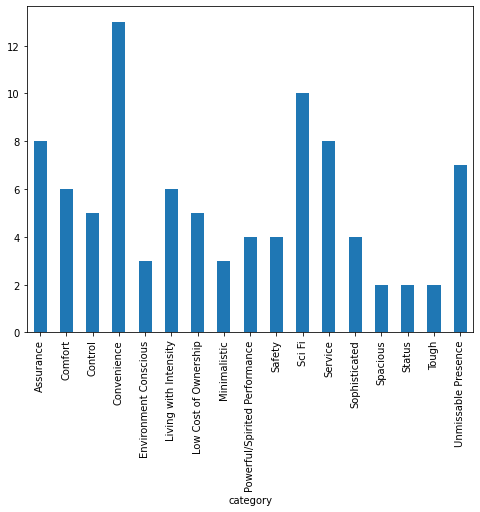

In [35]:
fig = plt.figure(figsize=(8,6))
df.groupby('category').processed_content.count().plot.bar(ylim=0)
plt.show()

In [36]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.processed_content).toarray()
labels = df.category_id
features.shape

(92, 4)

In [37]:
N = 2
for category, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names_out())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(category))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'Assurance':
  . Most correlated unigrams:
. easy
. driving
  . Most correlated bigrams:
. 
# 'Comfort':
  . Most correlated unigrams:
. driving
. good
  . Most correlated bigrams:
. 
# 'Control':
  . Most correlated unigrams:
. driving
. easy
  . Most correlated bigrams:
. 
# 'Convenience':
  . Most correlated unigrams:
. driving
. easy
  . Most correlated bigrams:
. 
# 'Environment Conscious':
  . Most correlated unigrams:
. easy
. driving
  . Most correlated bigrams:
. 
# 'Living with Intensity':
  . Most correlated unigrams:
. easy
. driving
  . Most correlated bigrams:
. 
# 'Low Cost of Ownership':
  . Most correlated unigrams:
. driving
. good
  . Most correlated bigrams:
. 
# 'Minimalistic':
  . Most correlated unigrams:
. easy
. driving
  . Most correlated bigrams:
. 
# 'Powerful/Spirited Performance':
  . Most correlated unigrams:
. easy
. driving
  . Most correlated bigrams:
. 
# 'Safety':
  . Most correlated unigrams:
. easy
. driving
  . Most correlated bigrams:
. 
# 'Sci

In [38]:
X_train, X_test, y_train, y_test = train_test_split(df['processed_content'], df['category'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [39]:
print(clf.predict(count_vect.transform(["my ride was awesome, it was so smooth"])))

['Sci Fi']


In [40]:
test_data['Categories'] = test_data['processed_content'].apply(lambda x: clf.predict(count_vect.transform([str(x)])))

In [41]:
test_data

,Brand,Content,processed_content,Categories
0,Scorpio,"16 hours ago - First introduced in 2007, the M...",hour ago first introduced mahindra getaway due...,[Service]
1,Scorpio,1 day ago - CarWale - Used Mahindra Scorpio [2...,day ago carwale used mahindra scorpio ex sale ...,[Convenience]
2,Scorpio,20 hours ago - CarWale - Used Mahindra Scorpio...,hour ago carwale used mahindra scorpio ex sale...,[Convenience]
3,Scorpio,1 hour ago - The 2017 Mahindra Scorpio Getaway...,hour ago mahindra scorpio getaway been spotted...,[Convenience]
4,Scorpio,19 hours ago - CarWale - Used Mahindra Scorpio...,hour ago carwale used mahindra scorpio vlx wd ...,[Convenience]
...,...,...,...,...
499738,Marazzo,@anandmahindra https://t.co/dngwphbRES. The p...,anandmahindra httpstcodngwphbres person singin...,[Convenience]
499739,Marazzo,@anandmahindra सर आप यह गाड़ी महान है अपने देश...,anandmahindra please mahindra marazzo ambulanc...,[Convenience]
499740,Marazzo,Mahindra Marazzo review. The shark inspired MU...,mahindra marazzo review shark inspired muv is ...,[Convenience]
499741,Marazzo,Mahindra cars price list in India *All prices ...,mahindra car price list india price ex showroo...,[Unmissable Presence]


In [42]:
test_data.to_excel('category_result_on_social_studio_data.xlsx')

In [84]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

c:\users\archana\anaconda3\envs\social-env\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
c:\users\archana\anaconda3\envs\social-env\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
c:\users\archana\anaconda3\envs\social-env\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
c:\users\archana\anaconda3\envs\social-env\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


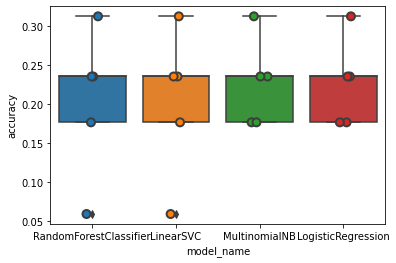

In [87]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [88]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.203676
LogisticRegression        0.227206
MultinomialNB             0.227206
RandomForestClassifier    0.203676
Name: accuracy, dtype: float64

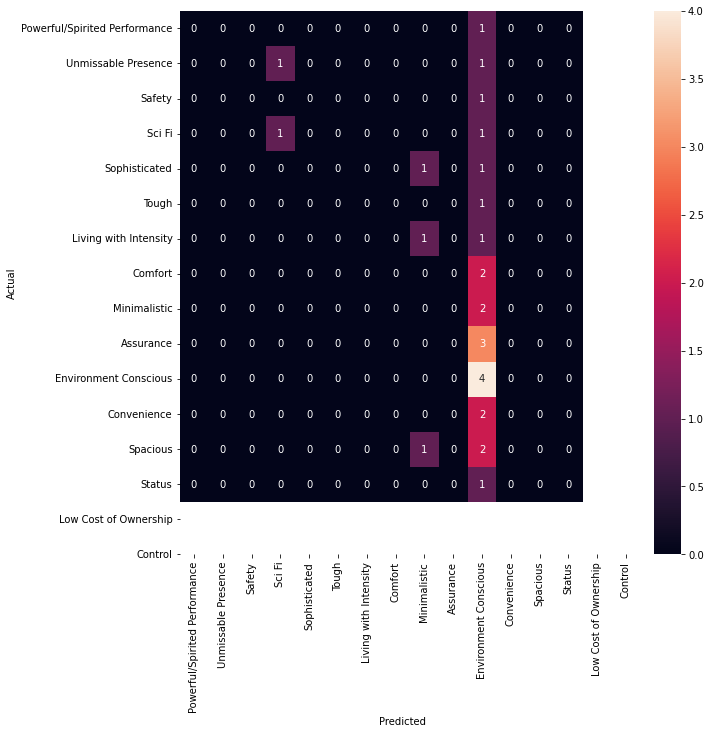

In [92]:
model = LogisticRegression()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.category.values, yticklabels=category_id_df.category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

IndexError: index 15 is out of bounds for axis 0 with size 15